In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
import warnings
warnings.filterwarnings('ignore')

# Imports específicos del proyecto
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

# Config visual
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
# Conexión BD
db = get_db_manager()

# Query unificado 5 grandes ligas domésticas
big5_query = """
SELECT 
    p.unique_player_id,
    p.player_name,
    p.normalized_name,
    p.league,
    p.season,
    p.team,
    p.nationality,
    p.position,
    p.age,
    p.birth_year,
    p.fbref_metrics,
    p.understat_metrics,
    p.data_quality_score,
    p.created_at
FROM footballdecoded.players_domestic p
WHERE p.league IN (
    'ENG-Premier League',
    'ESP-La Liga', 
    'ITA-Serie A',
    'GER-Bundesliga',
    'FRA-Ligue 1'
)
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

# Extracción a DataFrame
df_big5 = pd.read_sql(big5_query, db.engine)
db.close()

df_big5.head()

,unique_player_id,player_name,normalized_name,league,season,team,nationality,position,age,birth_year,fbref_metrics,understat_metrics,data_quality_score,created_at
0,4297cac0772af3c8,Ben White,Ben White,ENG-Premier League,2425,Arsenal,ENG,DF,26.0,1997.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.0...","{'understat_xa': '1.4500398263335228', 'unders...",1.0,2025-07-24 12:31:09.555900
1,258ed61985702bb2,Bukayo Saka,Bukayo Saka,ENG-Premier League,2425,Arsenal,ENG,"FW,MF",22.0,2001.0,"{'FK': '1', 'OG': '0', 'Crs': '117', 'Fld': '3...","{'understat_xa': '11.583731275051832', 'unders...",1.0,2025-07-24 12:31:15.730848
2,57f809b3be3768e0,David Raya,David Raya,ENG-Premier League,2425,Arsenal,ESP,GK,28.0,1995.0,"{'CS': '13', 'FK': '0', 'OG': '0', '/90': '0.0...","{'understat_xa': '0.09363602846860886', 'under...",1.0,2025-07-24 12:31:22.292846
3,bb58d04ee12cd7fd,Declan Rice,Declan Rice,ENG-Premier League,2425,Arsenal,ENG,MF,25.0,1999.0,"{'FK': '2', 'OG': '0', 'Crs': '164', 'Fld': '1...","{'understat_xa': '9.060594327747822', 'underst...",1.0,2025-07-24 12:31:28.623355
4,40384e981d1a5c3c,Ethan Nwaneri,Ethan Nwaneri,ENG-Premier League,2425,Arsenal,ENG,"FW,MF",17.0,2007.0,"{'FK': '1', 'OG': '0', 'Crs': '54', 'Fld': '5'...","{'understat_xa': '1.1617773352190852', 'unders...",1.0,2025-07-24 12:31:34.939683


In [8]:
# Posiciones únicas y conteos
print("POSICIONES DISPONIBLES:")
positions = df_big5['position'].value_counts().sort_index()
print(positions)

print(f"\nTotal posiciones únicas: {df_big5['position'].nunique()}")
print(f"Posiciones: {sorted(df_big5['position'].unique())}")

# Ver algunos ejemplos de cada posición
print(f"\nEjemplos por posición:")
for pos in sorted(df_big5['position'].unique()):
    sample_players = df_big5[df_big5['position'] == pos]['player_name'].head(3).tolist()
    print(f"  {pos}: {', '.join(sample_players)}")

POSICIONES DISPONIBLES:
position
DF       835
DF,FW     51
DF,MF    109
FW       359
FW,DF     23
FW,MF    312
GK       209
MF       571
MF,DF     81
MF,FW    222
Name: count, dtype: int64

Total posiciones únicas: 10
Posiciones: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']

Ejemplos por posición:
  DF: Ben White, Gabriel Magalhães, Jakub Kiwior
  DF,FW: Kieran Tierney, Julio Soler, Keane Lewis-Potter
  DF,MF: Oleksandr Zinchenko, Andrés García, Lamare Bogarde
  FW: Gabriel Jesus, Leandro Trossard, Nathan Butler-Oyedeji
  FW,DF: Mason Holgate, Martial Godo, Ryan Sessegnon
  FW,MF: Bukayo Saka, Ethan Nwaneri, Gabriel Martinelli
  GK: David Raya, Emiliano Martínez, Robin Olsen
  MF: Declan Rice, Jorginho, Martin Ødegaard
  MF,DF: Thomas Partey, Lewis Cook, Jack Hinshelwood
  MF,FW: Mikel Merino, Emi Buendía, John McGinn


In [7]:
# Filtrar MF como primera posición (MF, MF,FW, MF,DF)
df_midfielders = df_big5[df_big5['position'].str.startswith('MF')].copy()

print(f"Centrocampistas primera posición: {len(df_midfielders):,}")
print(f"Jugadores únicos: {df_midfielders['unique_player_id'].nunique():,}")

print(f"\nDesglose por posición exacta:")
print(df_midfielders['position'].value_counts())

print(f"\nPor liga:")
print(df_midfielders['league'].value_counts())

print(f"\nPrimeros 5:")
print(df_midfielders[['player_name', 'team', 'league', 'position', 'age']].head())

Centrocampistas primera posición: 874
Jugadores únicos: 860

Desglose por posición exacta:
position
MF       571
MF,FW    222
MF,DF     81
Name: count, dtype: int64

Por liga:
league
ESP-La Liga           197
ITA-Serie A           189
FRA-Ligue 1           170
ENG-Premier League    166
GER-Bundesliga        152
Name: count, dtype: int64

Primeros 5:
        player_name     team              league position   age
3       Declan Rice  Arsenal  ENG-Premier League       MF  25.0
9          Jorginho  Arsenal  ENG-Premier League       MF  32.0
14  Martin Ødegaard  Arsenal  ENG-Premier League       MF  25.0
15     Mikel Merino  Arsenal  ENG-Premier League    MF,FW  28.0
23    Thomas Partey  Arsenal  ENG-Premier League    MF,DF  31.0


In [10]:
# Extraer todas las métricas disponibles
fbref_metrics_all = set()
understat_metrics_all = set()

# Recorrer todos los registros para obtener métricas únicas
for _, row in df_midfielders.iterrows():
    if row['fbref_metrics']:
        fbref_metrics_all.update(row['fbref_metrics'].keys())
    if row['understat_metrics']:
        understat_metrics_all.update(row['understat_metrics'].keys())

print("MÉTRICAS FBREF DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_metrics_all))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref: {len(fbref_sorted)}")

print("\n\nMÉTRICAS UNDERSTAT DISPONIBLES:")
print("=" * 50)
understat_sorted = sorted(list(understat_metrics_all))
for i, metric in enumerate(understat_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal Understat: {len(understat_sorted)}")

# Muestra valores ejemplo de algunas métricas
print("\n\nEJEMPLOS VALORES (primer jugador):")
print("=" * 50)
sample_player = df_midfielders.iloc[0]
print("FBref sample:")
for key, value in list(sample_player['fbref_metrics'].items())[:5]:
    print(f"  {key}: {value}")

print("\nUnderstat sample:")
for key, value in list(sample_player['understat_metrics'].items())[:5]:
    print(f"  {key}: {value}")

MÉTRICAS FBREF DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. PKcon
64. 

In [ ]:
# Configuración para centrocampistas TOP mundial + contexto
midfielder_elite_config = {
    'metrics': [
        'minutes_played',               # Contexto disponibilidad
        'matches_played',               # Contexto partidos
        'goals',                        # Amenaza goleadora
        'assists',                      # Asistencias directas
        'expected_assists',             # Calidad creación
        'understat_npxg_plus_xa',       # Impacto ofensivo total
        'progressive_passes',           # Progresión del juego
        'key_passes',                   # Pases clave
        'passes_final_third',           # Llegada zona peligrosa
        'pass_completion_pct',          # Eficiencia técnica
        'tackles_won',                  # Recuperación defensiva
        'interceptions'                 # Lectura defensiva
    ],
    'titles': [
        'Minutes\nPlayed',
        'Matches\nPlayed',
        'Goals\nper 90',
        'Assists\nper 90',
        'Expected\nAssists', 
        'npxG + xA\n(Understat)',
        'Progressive\nPasses',
        'Key Passes\nper 90',
        'Passes Final\nThird',
        'Pass Accuracy\n%',
        'Tackles Won\nper 90',
        'Interceptions\nper 90'
    ],
    'negative_metrics': []
}

print("CONFIGURACIÓN ELITE CENTROCAMPISTAS + CONTEXTO:")
print("=" * 50)
for i, (metric, title) in enumerate(zip(midfielder_elite_config['metrics'], midfielder_elite_config['titles']), 1):
    context = " [CONTEXTO]" if metric in ['minutes_played', 'matches_played'] else ""
    print(f"{i:2d}. {metric:<25} → {title.replace(chr(10), ' ')}{context}")

CONFIGURACIÓN ELITE CENTROCAMPISTAS + CONTEXTO:
 1. minutes_played            → Minutes Played [CONTEXTO]
 2. matches_played            → Matches Played [CONTEXTO]
 3. goals                     → Goals per 90
 4. assists                   → Assists per 90
 5. expected_assists          → Expected Assists
 6. understat_npxg_plus_xa    → npxG + xA (Understat)
 7. progressive_passes        → Progressive Passes
 8. key_passes                → Key Passes per 90
 9. passes_final_third        → Passes Final Third
10. pass_completion_pct       → Pass Accuracy %
11. tackles_won               → Tackles Won per 90
12. interceptions             → Interceptions per 90

Total métricas: 12
Incluye: Contexto (2) + Creación (4) + Construcción (3) + Defensa (2) + Goles (1)


In [13]:
# Buscar jugadores en el DataFrame
pedri_search = df_midfielders[df_midfielders['player_name'].str.contains('Pedri', case=False, na=False)]
bellingham_search = df_midfielders[df_midfielders['player_name'].str.contains('Bellingham', case=False, na=False)]

print("PEDRI encontrado:")
if not pedri_search.empty:
    for _, player in pedri_search.iterrows():
        print(f"  {player['unique_player_id']} - {player['player_name']} ({player['team']}, {player['league']})")
else:
    print("  No encontrado")

print("\nBELLINGHAM encontrado:")
if not bellingham_search.empty:
    for _, player in bellingham_search.iterrows():
        print(f"  {player['unique_player_id']} - {player['player_name']} ({player['team']}, {player['league']})")
else:
    print("  No encontrado")

PEDRI encontrado:
  8c50fb1a1662d90f - Pedri (Barcelona, ESP-La Liga)

BELLINGHAM encontrado:
  1b18fe1684f965aa - Jude Bellingham (Real Madrid, ESP-La Liga)


ValueError: s must be a scalar, or float array-like with the same size as x and y

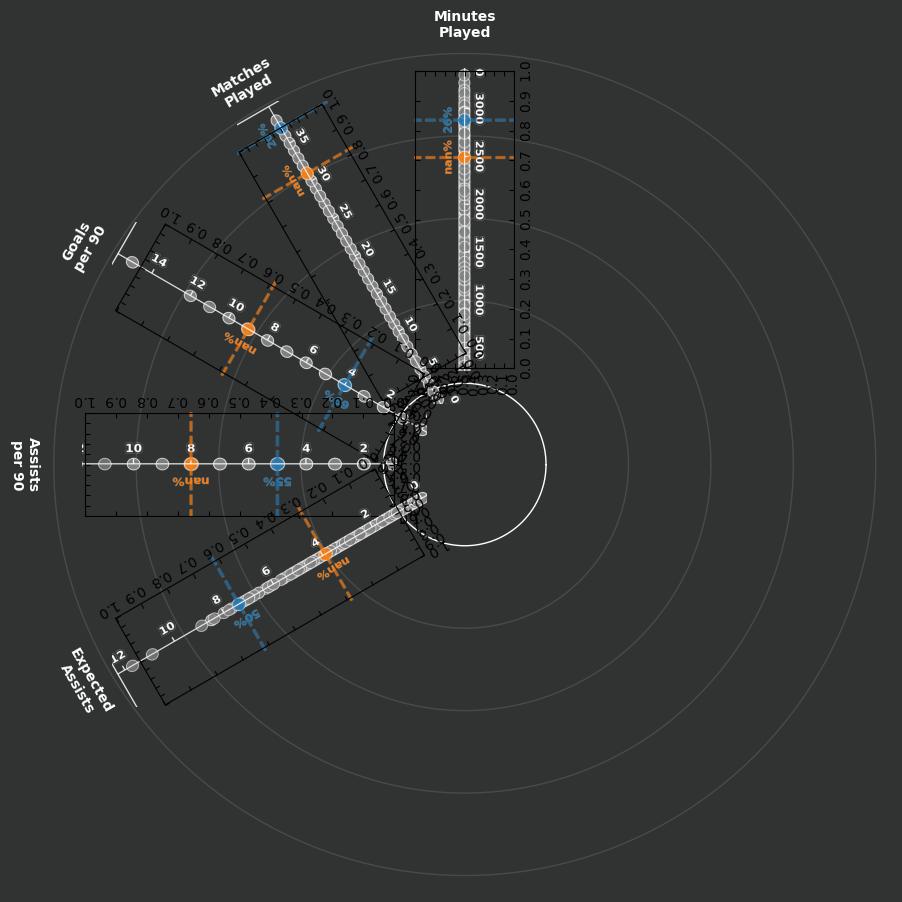

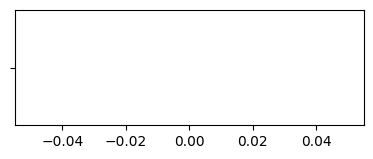

In [14]:
# Import función
import sys
sys.path.append('../viz')
from swarm_radar import create_swarm_radar

# IDs de los jugadores (ajusta según resultado anterior)
pedri_id = "8c50fb1a1662d90f"  # Reemplaza con el ID real
bellingham_id = "1b18fe1684f965aa"  # Reemplaza con el ID real

# Configuración
player_ids = [pedri_id, bellingham_id]
comparison_text = "Elite midfielders comparison - Big 5 Leagues 2024-25. Min 800 minutes played for percentiles."

# Crear radar
fig = create_swarm_radar(
    df=df_midfielders,
    player_ids=player_ids,
    metrics_config=midfielder_elite_config,
    comparison_text=comparison_text,
    min_minutes=800,
    colors=['#1f77b4', '#ff7f0e'],  # Azul Pedri, Naranja Bellingham
    save_path='pedri_vs_bellingham_radar.png'
)

plt.show()